# Estimating variance with basis functions
This notebook uses the set up in the linear-nonlinear.ipynb notebook to estimate the form of the (estimated) disturbances using a polynomial basis. 

In [ ]:
import numpy as np
from numpy.linalg import norm
from scipy.stats import distributions as iid
import pandas as pd

In [2]:
# define true function (see linear-nonlinear notebook for inspiration)
f0 = lambda x: 1 + np.sin(x) # True function

# Factory function for phi_k(x); simple polynomial
phi_factory = lambda c,s=1: lambda x: x**c

In [3]:
# heteroskedastic DGP
def dgp(N,sigma_u,f0,beta=1):
    X = iid.uniform(loc=0,scale=2*np.pi).rvs(size=(N,1))

    u = iid.norm(scale=sigma_u).rvs(size=(N,1))
    u = u*f0(X) # create heterskedasticity

    y = (X*beta+u).reshape(N,1)

    return X,y

N = 100
X,y = dgp(N,1,f0)

(-1.0, 10.0)

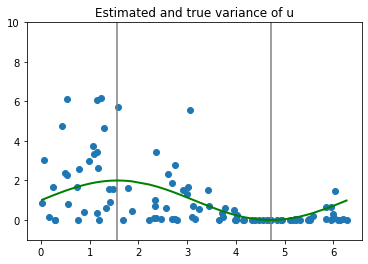

In [4]:
# regress and get errors
e = y - X*np.linalg.inv(X.T@X)@X.T@y

# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(X, e**2)
ax.axvline(x = np.pi/2, color = 'grey')
ax.axvline(x = 3*np.pi/2, color = 'grey')

xp = np.sort(X.flatten())
ax.plot(xp, [f0(x) for x in xp], color = 'green', linewidth=2, label = 'True variance of u')
ax.set_title("Estimated and true variance of u")
ax.set_ylim((-1,10)) # ignore high outliers to get a better look

In [5]:
## Now estimate with the basis functions defined above
## let's try to the 4th power
K=5

# Divide up domain
Domain = np.linspace(0,2*np.pi,100).tolist()
phis = {k:phi_factory(Domain[x]) for k,x in enumerate(range(1,len(Domain),len(Domain)//K))}
phis[0] = lambda x: 1 # Constant function

TX = {}
for k in range(K):
    TX['phi_%d' % k] = [phis[k](x) for x in X.flatten()]
    TX['phi_%d' % k]

TX = pd.DataFrame(TX)

u2 = e**2

try: # If e isn't a DataFrame make it one
    u2 = pd.DataFrame({'u':u2})
except ValueError: # Guess it is!
    pass

alpha = pd.DataFrame(np.linalg.lstsq(TX, u2,rcond=None)[0],index=TX.columns)

# Check fit:
e = y.squeeze() - (TX@alpha).squeeze()
e.var()

7.383399661739618

In [7]:
alpha # we could test the values of these for h_0: phi_i = 0 for each i

,0
phi_0,1.754705
phi_1,0.989435
phi_2,-0.545608
phi_3,0.076099
phi_4,-0.003283


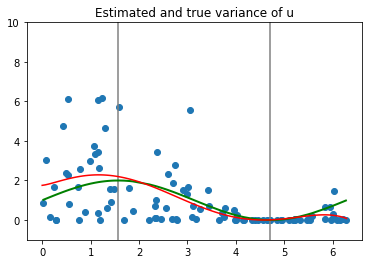

In [6]:
def fhat(x,alpha):
    try: # Make alpha 1-d for calculations here
        alpha = alpha.squeeze()
    except AttributeError: # Maybe a list?
        pass
    
    yhat = 0
    for k,phik in phis.items():
        yhat += alpha[k]*phik(x)

    return yhat

Domain = np.linspace(0,2*np.pi,100).tolist()

_ = ax.plot(Domain,[fhat(x,alpha) for x in Domain], color = 'red')
fig